# Problem Set 1 (40 points) -   Take-Home

You have been tasked to implement a predictor that will _rank_ documents according to their relevancy to a given query. 

You will use the [LETOR 4.0 dataset MQ2007]( https://arxiv.org/pdf/1306.2597.pdf) that has already been downloaded and is available in the `data` folder.

Each row is a query-document pair. The first column is the relevance label of this pair, the second column is query id, the following columns are features, and the end of the row is comment about the pair, including id of the document. The larger the relevance label, the more relevant the query-document pair. A query-document pair is represented by a 46-dimensional feature vector. 

## PS1.A (5 points) - Data Exploration

Create a pandas frame of the dataset and _print_ the first 5 rows in format where the first row will show the column names of the dataset. Instead of the feature names you can conveniently use the column index as a name.  

Is the 2nd column which is the query id a feature or not ?  Answer the question by coding the production of the $\mathbf x$ feature container and the $label y$ label container.  

In [1]:
# Insert the code here
import pandas

#Convert whatever the heck this is right to CSV
file_in = open("Querylevelnorm.txt", "r") 
file_out = open("Querylevelnorm.csv", "w")
column_names=["relevance", "qid"]
column_names.extend(str(i + 1) for i in range(46))
file_out.write(",".join(column_names))
file_out.write("\n")
for line in file_in:
    components = line.split(" ")
    components = components[:48]
    for i in range(47):
        components[i+1] = components[i+1].split(":")[1]
    file_out.write(",".join(components))
    file_out.write("\n")



In [2]:
from sklearn.model_selection import train_test_split 

#And now read it into the dataframes for train and test data
dataframe = pandas.read_csv("Querylevelnorm.csv")
train, test = train_test_split(dataframe, test_size=0.2)
X_test = test.drop(["relevance", "qid"], axis=1).iloc[:500]
y_test = test["relevance"].iloc[:500]
X_train = train.drop(["relevance", "qid"], axis=1).iloc[:5000]
y_train = train["relevance"].iloc[:5000]

print(X_train.head(5))
print(y_train.head(5))

              1         2         3    4         5    6    7    8    9   10  \
53191  0.002930  0.333333  0.500000  0.0  0.006836  0.0  0.0  0.0  0.0  0.0   
15837  0.014019  0.000000  0.833333  0.0  0.023419  0.0  0.0  0.0  0.0  0.0   
15642  0.264386  0.000000  0.000000  0.0  0.264386  0.0  0.0  0.0  0.0  0.0   
61009  0.056641  0.000000  0.000000  0.0  0.056641  0.0  0.0  0.0  0.0  0.0   
50577  0.119221  0.000000  0.000000  0.0  0.119221  0.0  0.0  0.0  0.0  0.0   

       ...        37        38        39        40        41        42  \
53191  ...  0.700314  0.445688  0.215024  0.345820  0.005860  0.028169   
15837  ...  0.657504  0.513192  0.426858  0.464825  0.004556  0.023468   
15642  ...  0.730436  0.611270  0.574050  0.646457  0.025523  0.029412   
61009  ...  0.980267  0.851066  0.885094  0.754999  0.006752  0.333333   
50577  ...  0.653624  0.629436  0.766006  0.646783  0.072479  0.104167   

             43        44        45   46  
53191  0.000000  0.571429  0.270000  

## PS1.B (20 points)

Consult your textbook notebook `#4`` (the one that corresponds to Chapter 4) and express the problem of ranking as a regression problem. State the problem and implement the solution using the polynomial basis functions just like in [this notebook](https://pantelis.github.io/data-mining/aiml-common/lectures/regression/linear-regression/linear_regression.html). Solve the linear regression problem using SGD. Report the train and test MSE as a function of the epochs. 


This ranking problem can be turned into a regression problem by treating the ranking as a continuous variable. We can use linear regression by applying a polynomial basis function and then performing linear regression on the transformed dataset. To do this, we will be preprocessing the data using the dimensionality reduction, polynomial basis function, and standardization facilities of Scikit, and then we will implement multiple linear regression and stochastic gradient descent from scratch using the absolute undeniable TRUTH of mathematics, and use the algorithm to train a model on the preprocessed data.

We are first normalizing our data such that the mean is 0, so we do not need to worry about intercepts. Our prediction is therefore

$\hat{y_i} = w_1x_{i1} + w_2x_{i2} + ... + w_mx_{im}$

And our error when predicting $n$ data points will be

$Err = \frac{1}{n}\sum_{i=1}^{n}(\hat{y_i}-y_i)^2$

Now we derive this with respect to a given weight, say, $w_j$.

$\frac{dErr}{dw_j} = \frac{d}{dw_j} \frac{1}{n}\sum_{i=1}^{n}(\hat{y_i}-y_i)^2$

$=\frac{1}{n}\sum_{i=1}^{n} \frac{d}{dw_j} (\hat{y_i}-y_i)^2$

$\frac{d}{dw_j} (\hat{y_i}-y_i)^2 = 2(\hat{y_i}-y_i)(\frac{d}{dw_j}(\hat{y_i}-y_i))$

$\frac{d}{dw_j}(\hat{y_i}-y_i) = \frac{d}{dw_j}\hat{y_i} = \frac{d}{dw_j}w_jx_{ij} = x_{ij}$

$\frac{dErr}{dw_j} = \frac{2}{n}\sum_{i=1}^{n}(\hat{y_i}-y_i)x_{ij}$

In the case of stoachastic gradient descent, we have $n=1$

$\frac{dErr}{dw_j} = 2(\hat{y}-y)x_j$

We now have the mathematical TRUTH we need to implement SGD from scratch. Even in C if we so chose. We'll test our algorithm on some toy data well-suited to multiple linear regression to make sure we have not made a fatal error in implementation or in mathematical reasoning, and then we'll test it on the dataset.

initializing
Training


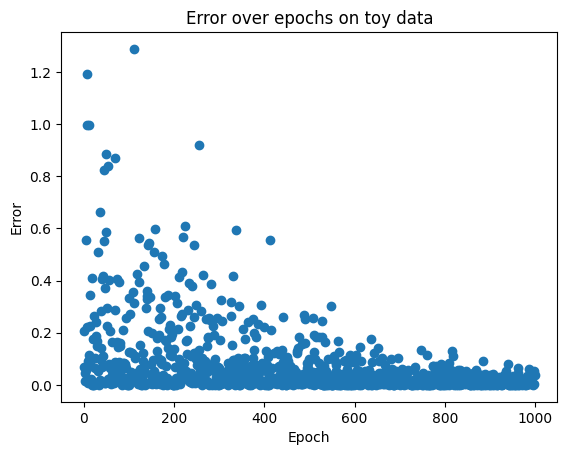

initializing
Training


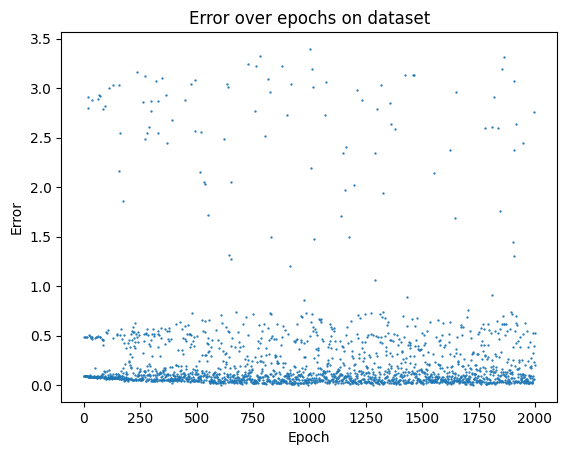

In [54]:
# Insert code here
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import numpy
import random
from matplotlib import pyplot as plt

class Model:
    def __init__(self, X: list[list[float]], y: list[float], store_errors: bool = False, error_skip_length: int = 1, X_test: list[list[float]] = None, y_test: list[float] = None):
        assert len(X) > 0
        print("initializing")
        self.store_errors = store_errors
        self.error_skip_length = error_skip_length
        self.errors_train = [] # Will store the MSE as a function of epochs 
        self.errors_test = []
        self.coefficients = [0 for i in range(len(X[0]))]
        self.y_intercept = numpy.mean(y)
        x_t = numpy.transpose(X)
        self.x_intercepts = []
        for column in range(len(x_t)):
            self.x_intercepts.append(numpy.mean(x_t[column]))
        
        #Normalize the data
        self.X = X.copy()
        for row in range(len(self.X)):
            self.normalize(self.X[row])
        self.y = y.copy()
        for i in range(len(self.y)):
            self.y[i] -= self.y_intercept

        self.X_test = X_test
        self.y_test = y_test
    #Normalize inputs
    def normalize(self, x: list[float]):
        assert len(x) == len(self.coefficients)
        for i in range(len(x)):
                x[i] -= self.x_intercepts[i]

    #Predict the normalized y value given normalized x values
    def predict_normalized(self, x: list[float]) -> float:
        assert len(x) == len(self.coefficients)
        return numpy.dot(self.coefficients, x)


    #Predict the y value given x values
    def predict(self, x: list[float]) -> float:
        assert len(x) == len(self.coefficients)
        x_normalized = x.copy()
        self.normalize(x_normalized) #Normalize the input
        return self.predict_normalized(x_normalized) + self.y_intercept #Denormalize the output
    
    def fit(self, epochs: int, learning_rate: float):
        print("Training")
        self.errors_test = []
        self.errors_train = []
        for i in range(epochs):
            rand_index = random.randint(0, len(self.X)-1)
            x = self.X[rand_index]
            prediction = self.predict_normalized(x)
            #Now to update the weights
            for weight_index in range(len(self.coefficients)):
                gradient = 2*(prediction - self.y[rand_index])*x[weight_index] 
                self.coefficients[weight_index] -= learning_rate * gradient

            # Calculate MSE for train and test data and store it
            # This is just for metrics, but unfortunately takes a vast majority
            # of the computational power in this algorithm.
            # As such, I have added an extra parameter, "error_skip_length"
            # This will be used so that it only finds and stores the MSE at every error_skip_length'th epoch.
            if self.store_errors and i % self.error_skip_length == 0:
                if self.X_test != None and self.y_test != None:
                    assert len(self.X_test) > 0
                    assert len(self.X_test[0]) == len(self.X[0])

                    predictions = []
                    for j in range(len(self.X_test)):
                        predictions.append(self.predict(self.X_test[j]))
                    mse = mean_squared_error(self.y_test, predictions)
                    print("Epoch " + str(i + 1) + " test mse: " + str(mse))
                    self.errors_test.append(mean_squared_error(self.y_test, predictions))
     

                predictions = []
                for j in range(len(self.X)):
                    predictions.append(self.predict_normalized(self.X[j]))
                mse = mean_squared_error(self.y, predictions)
                print("Epoch " + str(i + 1) + " train mse: " + str(mse))
                self.errors_train.append(mse)
    

#To test the validity of our algorithm, we will test it on some toy data with 3 features
toy_data_x= []
toy_data_y = []
for i in range(10000):
    gen_w = random.random()
    gen_x = random.random()
    gen_z = random.random() + 10
    gen_y = gen_w + gen_x + gen_z + random.random() * 0.2 + 10
    toy_data_x.append([gen_w, gen_x, gen_z])
    toy_data_y.append(gen_y)

model = Model(toy_data_x, toy_data_y, store_errors=True)
model.fit(1000, 0.01)
x_axis = [i for i in range(len(model.errors_train))]
plt.plot(x_axis, model.errors_train)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Train MSE over epochs on toy data")
plt.show()

#Now we will regress on the actual dataset using polynomial basis functions. HERE GOES!!!!
error_skip_length = 100

poly = PolynomialFeatures(2)
pca = PCA(n_components=10)
X_train_reduced = PCA.fit(X_train)
X_train_transformed = poly.fit_transform(X_train).tolist()
y_train_transformed = y_train.values.tolist()

X_test_transformed = poly.fit_transform(X_test).tolist()
y_test_transformed = y_test.values.tolist()

model = Model(X_train_transformed, y_train_transformed, store_errors=True, error_skip_length=error_skip_length, X_test=X_test_transformed, y_test=y_test_transformed)
model.fit(10000, 0.0001)

x_axis = [error_skip_length * i + 1 for i in range(len(model.errors_train))]
plt.plot(x_axis, model.errors_train)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Train MSE over epochs on dataset")
plt.show()

x_axis = [error_skip_length * i + 1 for i in range(len(model.errors_train))]
plt.plot(x_axis, model.errors_test)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Test MSE over epochs on dataset")
plt.show()

So, we can see that the algorithm performed extremely well on the toy data (which is to be expected as the toy data was basically designed to be well-suited to multiple linear regression). On the actual data, it was still able to improve a little bit from training. In our implementation, the behavior of the model before training would be to simply predict the relevance as the mean of the relevances in the test data. The drop in MSE when predicting on both the test and training data shows that it gained some ability to discriminate between relevant and irrelevant queries.

initializing
Training


AssertionError: 

## PS1.C (15 points)

Repeat the exercise of PS 1.B with the additional regualrization approach of  [this notebook](https://pantelis.github.io/data-mining/aiml-common/lectures/regression/linear-regression/linear_regression.html). Optimize $\lambda$ showing the train and test MSE as a function of this hyperparameter and for the optimal value of $\lambda$ plot the final train and test MSE as a function of the epochs.

So, when doing linear regression, it looks like we are now adding an extra term $\frac{\lambda}{2}||w||^2$. Our loss function for $m$ features is now

$Err = (\hat{y_i}-y_i)^2 + \frac{\lambda}{2}||w||^2$

$= (\hat{y_i}-y_i)^2 + \frac{\lambda}{2}\sqrt{w_1^2 + w_2^2 + ... + w_m^2}^2$

$= (\hat{y_i}-y_i)^2 + \frac{\lambda}{2}(w_1^2 + w_2^2 + ... + w_m^2)$

To calculate the derivative of this term with respect to a weight $w_j$, it looks like it's just going to be the power rule to give us

$\frac{dErr}{dw_j} = 2(\hat{y}-y)x_j + \lambda w_j$

Which gives us our new gradient.

I will optimize this hyperparameter using optuna.

In [31]:
import optuna

class Model_2:
    def __init__(self, X: list[list[float]], y: list[float], special_hyperparameter: float):
        assert len(X) > 0
        print("initializing")
        self.special_hyperparameter = special_hyperparameter
        self.errors = [] # Will store the MSE as a function of epochs 
        self.coefficients = [0 for i in range(len(X[0]))]
        self.y_intercept = numpy.mean(y)
        x_t = numpy.transpose(X)
        self.x_intercepts = []
        for column in range(len(x_t)):
            self.x_intercepts.append(numpy.mean(x_t[column]))
        
        #Normalize the data
        self.X = X.copy()
        for row in range(len(self.X)):
            self.normalize(self.X[row])
        self.y = y.copy()
        for i in range(len(self.y)):
            self.y[i] -= self.y_intercept

    #Normalize inputs
    def normalize(self, x: list[float]):
        assert len(x) == len(self.coefficients)
        for i in range(len(x)):
                x[i] -= self.x_intercepts[i]

    #Predict the normalized y value given normalized x values
    def predict_normalized(self, x: list[float]) -> float:
        assert len(x) == len(self.coefficients)
        return numpy.dot(self.coefficients, x)


    #Predict the y value given x values
    def predict(self, x: list[float]) -> float:
        assert len(x) == len(self.coefficients)
        x_normalized = x.copy()
        self.normalize(x_normalized) #Normalize the input
        return self.predict_normalized(x_normalized) + self.y_intercept #Denormalize the output
    
    def fit(self, epochs: int, learning_rate: float):
        print("Training")
        self.errors = []
        for i in range(epochs):
            rand_index = random.randint(0, len(self.X)-1)
            x = self.X[rand_index]
            prediction = self.predict_normalized(x)
            error = (prediction - self.y[rand_index])**2 + self.special_hyperparameter/2 * numpy.linalg.norm(x)**2
            self.errors.append(error)
            
            #Now to update the weights
            for weight_index in range(len(self.coefficients)):
                gradient = 2*(prediction - self.y[rand_index])*x[weight_index] + self.special_hyperparameter * self.coefficients[weight_index]
                self.coefficients[weight_index] -= learning_rate * gradient


errors = []

def train_regressor(trial):
    special_hyperparameter = trial.suggest_float("special_hyperparameter", low = 0, high=10)
    model = Model_2(X_train_transformed, y_train_transformed, special_hyperparameter)
    model.fit(2000, 0.00005)


    y_pred = []
    for i in range(len(X_test_transformed)):
        y_pred.append(model.predict(X_test_transformed[i]))
    error = mean_squared_error(y_test_array, y_pred)
    errors.append(error)
    return error

study = optuna.create_study(direction='minimize')
study.optimize(train_regressor, n_trials=10)

x_axis = [i for i in range(len(errors))]
plt.scatter(x_axis, errors)
plt.xlabel("Special hyperparameter value")
plt.ylabel("Mean squared error of final model")
plt.title("Hyperparameter optimization")
plt.show()



[I 2023-10-23 01:13:29,903] A new study created in memory with name: no-name-6928098b-19c2-4449-9aa2-d29a9a70e35a


initializing


[I 2023-10-23 01:13:31,097] Trial 0 finished with value: 0.31807587396832937 and parameters: {'special_hyperparameter': 0.8692024671166376}. Best is trial 0 with value: 0.31807587396832937.


Training
initializing
Training


[I 2023-10-23 01:13:32,301] Trial 1 finished with value: 0.3229123207577804 and parameters: {'special_hyperparameter': 1.6774679281695148}. Best is trial 0 with value: 0.31807587396832937.


initializing


[I 2023-10-23 01:13:33,494] Trial 2 finished with value: 0.31895821248977824 and parameters: {'special_hyperparameter': 0.02809936890191045}. Best is trial 0 with value: 0.31807587396832937.


Training
initializing


[I 2023-10-23 01:13:34,660] Trial 3 finished with value: 0.3184831084273735 and parameters: {'special_hyperparameter': 2.034552168234396}. Best is trial 0 with value: 0.31807587396832937.


Training
initializing


[W 2023-10-23 01:13:34,975] Trial 4 failed with parameters: {'special_hyperparameter': 9.293942471079527} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/msbean/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_20082/524064310.py", line 63, in train_regressor
    model = Model_2(X_train_transformed, y_train_transformed, special_hyperparameter)
  File "/tmp/ipykernel_20082/524064310.py", line 19, in __init__
    self.normalize(self.X[row])
  File "/tmp/ipykernel_20082/524064310.py", line 28, in normalize
    x[i] -= self.x_intercepts[i]
KeyboardInterrupt
[W 2023-10-23 01:13:34,975] Trial 4 failed with value None.


KeyboardInterrupt: 

Wow that did not do much at all. Nevertheless, it was successfully incorporated and did not have a significantly detrimental effect on our model. We can see that the hyperparameter had a very minor effect on the model's accuracy, with the best being when it was set to 1.669798044613301. I cannot say that this definitively improved the model's performance overall. I'm sure that in another situation, this added functionality to the Model_2 class could prove useful.
<br><br>
In the end, our trained model has somewhat better performance than taking the blunt approach of just predicting 0 for the relevance in all cases, which is by far the most common classification of relevance in the dataset. Examining its predictions, it appears to predict mostly 0's and it sparsely predicts 1 when it detects a spark of relevance, as can be seen in the array of its predictions below where we snap the predictions to the closest integer. Most importantly, by deriving cost functions with respect to weights and implementing stochastic gradient descent from scratch, we have laid bare the TRUTH, which can be invoked to perform this technique regardless of what programming language we use.

In [ ]:
y_pred = []
for i in range(len(X_test_transformed)):
    y_pred.append(round(model.predict(X_test_transformed[i])))
print(y_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 